# Why should I ReLU?

We know that mathematically, ReLU introduces nonlinearities between linear convolutional layers. Without ReLU, multiple linear conv layers can simply be condensed into a simgle layer.

In this tutorial, we will explore an alternative visual perspective as to how ReLU might be helping. It is assumed that the reader is already familiar with Convolutions, output activation volumes and numpy. There are several excellent articles online on these topics and I wont attempt to duplicate that information here. For a quick refresher, refer to awesome video summary: https://www.youtube.com/watch?v=FmpDIaiMIeA&t=3s

In [1]:
# Lets get some essential; imports out of the way.
import numpy as np
import utils
import matplotlib.pyplot as plt
%matplotlib inline 

from keras import backend as K

Using TensorFlow backend.


Lets start by loading a pretraing vggnet. We will replace all ReLUs with linear activations to examine the effect on output with/without ReLU.

In [3]:
from keras.applications.vgg16 import VGG16
from keras.activations import linear

# Load a pretrained vggnet but make all activations linear
model = VGG16()
for layer in model.layers:
    if hasattr(layer, 'activation'):
        layer.activation = linear
        
modified_model = utils.apply_modifications(model)

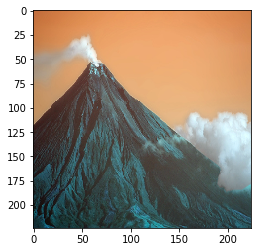

In [4]:
# Load a simple test image.
img = utils.load_img("../images/volcano.jpg", target_size=(224, 224))
plt.imshow(img)

`block1_conv1` has shape `(None, 224, 224, 64)` and uses 3 X 3 filter kernel. What this means is that:
- It has 64, 3 X 3 learnable filters, each of which is trying to look for some pattern spatially within 224 X 224 input image. 
- If you think about it, dot product is related to cosine similarity. So a high value after computing `dot(img[:3, :3, :], 3 X 3 filter)` indicates that it found the desired pattern in the `img[:3, :3, :]` spatial location.

Lets try to visualize what these filters are computing.

In [6]:
# Lets take the first filter and see what it is computing.
conv1 = modified_model.layers[1]

# Input to the vggnet is float32.
# Also input layer expects a batch.
img_batch = np.array([img], dtype=np.float32)

# Lets build a function to compute conv1 output
out_fn = K.function([modified_model.input], [conv1.output])
output = out_fn([img_batch])[0]
print output.shape

(1, 224, 224, 64)


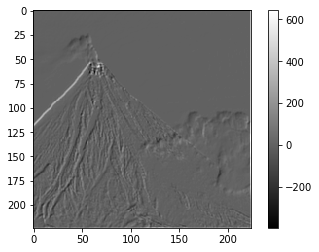

In [7]:
#lets see what the first filter computes.
out = output[0, :, :, 0].copy()
plt.imshow(out, cmap='gray')
plt.colorbar()

It's a bit difficult to notice, but we want to focus on large values. Recall that after computing dot product, large values indicate a higher degree of match with the conv filter. 

Lets discard small values (output < 0). This should allow us to see what regions the filter is trying to match more clearly.

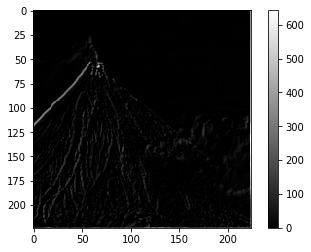

In [8]:
out = output[0, :, :, 0].copy()
out[out < 0] = 0
plt.imshow(out, cmap='gray')
plt.colorbar()

This is what ReLU is doing! It makes sense to ignore regions that dont match with the conv filter. For example, an eye filter should only output high values where it sees an eye and low everywhere else. 

What about negative values? With dot product (cosine similarity), a large negative value implies a match but in opposite direction. What the heck is opposite of a match? Lets find out...

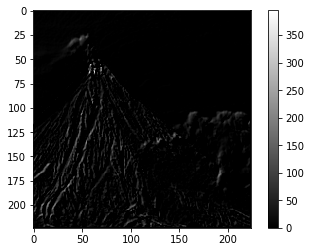

In [9]:
out = output[0, :, :, 0].copy()

# Lets remove positive values and flip negative to positive values.
out[out > 0] = 0
out = -out
plt.imshow(out, cmap='gray')
plt.colorbar()

Ok. I cant really make any sense of it. Moving on...

Lets try to visualize that the filter itself looks like. This should correspond to some kind of 45 degree edge detector.

In [10]:
# get_weights returns a list with two weights. The conv filter weights and the bias weights. 
filters = conv1.get_weights()[0]
print filters.shape
print filters[:, :, :, 0]

(3, 3, 3, 64)
[[[ 0.42947057  0.55037946  0.4800154 ]
  [ 0.373467    0.44007453  0.4085474 ]
  [-0.06136011 -0.08138704 -0.06514555]]

 [[ 0.27476987  0.34573907  0.31047726]
  [ 0.03868078  0.04063221  0.05020237]
  [-0.36722335 -0.45350131 -0.40338343]]

 [[-0.05746817 -0.05863491 -0.05087169]
  [-0.26224968 -0.33066967 -0.28522751]
  [-0.35009676 -0.4850302  -0.41851634]]]


Since input image has 3 channels, we have 3 corresponding 3 X 3 weights for each channel. This makes it a bit difficult to visualize what the filter is doing overall on an RGB image.

Lets try visualizing each of them individually.

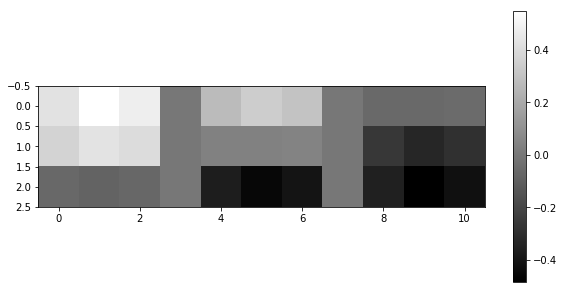

In [11]:
# Stitch all 3 images into one
stitched = utils.stitch_images(filters[:, :, :, 0], margin=1)
plt.figure(figsize=(10,5))
plt.imshow(stitched, cmap='gray')
plt.colorbar()

These filters correspond to the image channels B, G, R. So this filters looks like it is trying to find an edge that separates sky and grass. 

Finally, lets see output from all 64 filters. We will apply ReLU on output to make the positive values stand out. The shape of output is `(1, 224, 224, 64)`

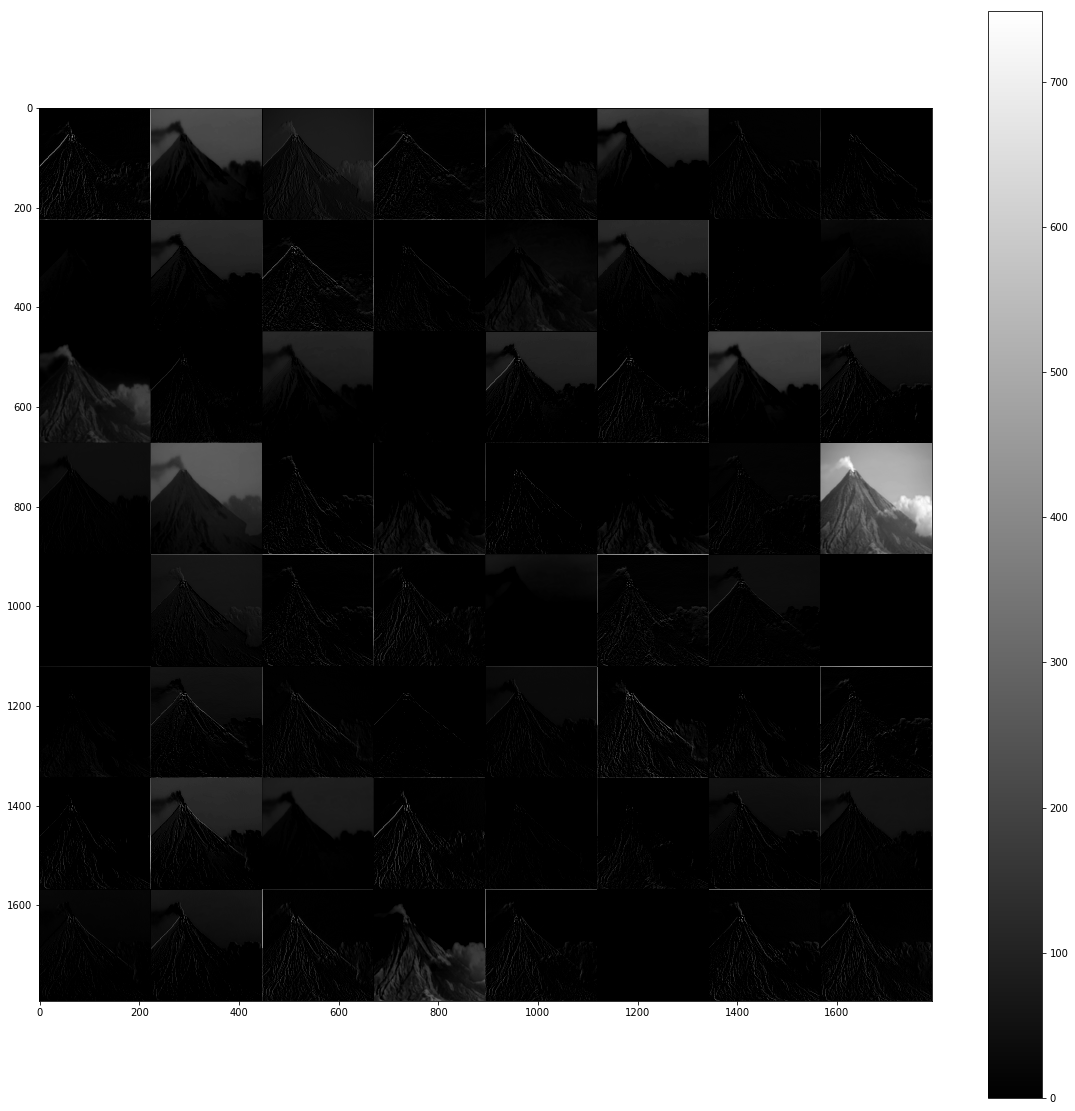

In [12]:
# ReLU.
out = output.copy()
out[out < 0] = 0

# Remove the first axis.
out = np.squeeze(out)

# We want to move axis=2 (64) to 0 so that we can treat `out` as a slices of images with (h, w) values.
out = np.moveaxis(out, 2, 0)

# Generate an 8 X 8 image mosaic to see everything side by side.
stitched = utils.stitch_images(out, cols=8, margin=0)
plt.figure(figsize=(20,20))
plt.imshow(stitched, cmap='gray')
plt.colorbar()

Looks like filter 31 detects the sky and clouds. Even though we see a grayscaled mountain, it is important to ignore the dark values and only focus on white (high values). We can see the effect more clearly by normalizing output values to [0, 1] and thresholding the image to see top x% activations.

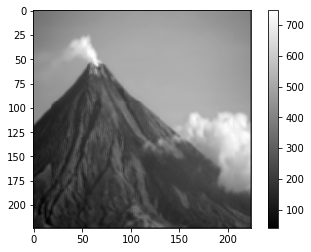

In [13]:
#This is the filter output in question
out = output[0, :, :, 31].copy()
plt.imshow(out, cmap='gray')
plt.colorbar()

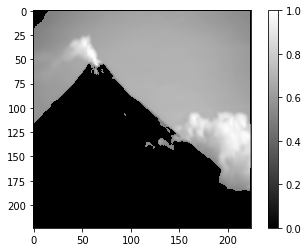

In [14]:
# ReLU
out[out < 0] = 0

# Normalize to [0, 1]
out /= np.max(out)

# threshold at 0.5
out[out < 0.5] = 0
plt.imshow(out, cmap='gray')
plt.colorbar()

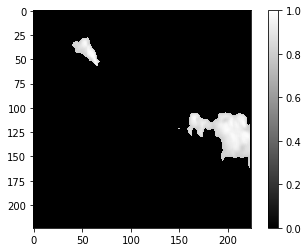

In [15]:
# Threshold to top 20% of the activation to see what this 31st filter is *really* trying to detect.
out[out < 0] = 0
out /= np.max(out)
out[out < 0.8] = 0
plt.imshow(out, cmap='gray')
plt.colorbar()

>This caught me by surprise. But a neuron on the first conv layer is already capable of detecting smoke or cloud like objects.